In [1]:
import glob
from glob import iglob
import os
import cv2
import time
import numpy as np
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
%matplotlib inline
# from lesson_functions import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def load_data(root_dir):
    """
        Data is provided in the folders vehicles and non-vehicles
    """
    file_list = [f for f in iglob(root_dir, recursive=True) if os.path.isfile(f)]
    return file_list

## Load the Data
    Load the training data provided. 

No of car samples 8792
No of not car samples 8968


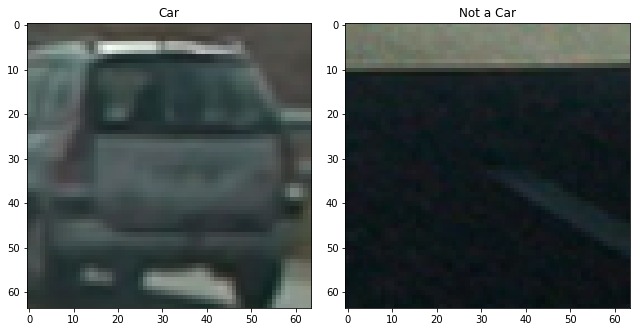

In [3]:
cars = load_data('./vehicles/**/*.png')
notcars = load_data('./non-vehicles/**/*.png')

print('No of car samples' , len(cars))
print('No of not car samples' , len(notcars))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,12))

car_image = plt.imread(cars[0])
notcar_image = plt.imread(notcars[0])

ax1.imshow(car_image)
ax1.set_title("Car")

ax2.imshow(notcar_image)
ax2.set_title("Not a Car")

plt.tight_layout()

## Extract the features from the images

In [4]:
# Define a function to return HOG features and visualization
def bin_spatial(img, size=(32,32), ravel=True):
    features = cv2.resize(img, size)
    if ravel:
        features = features.ravel()
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

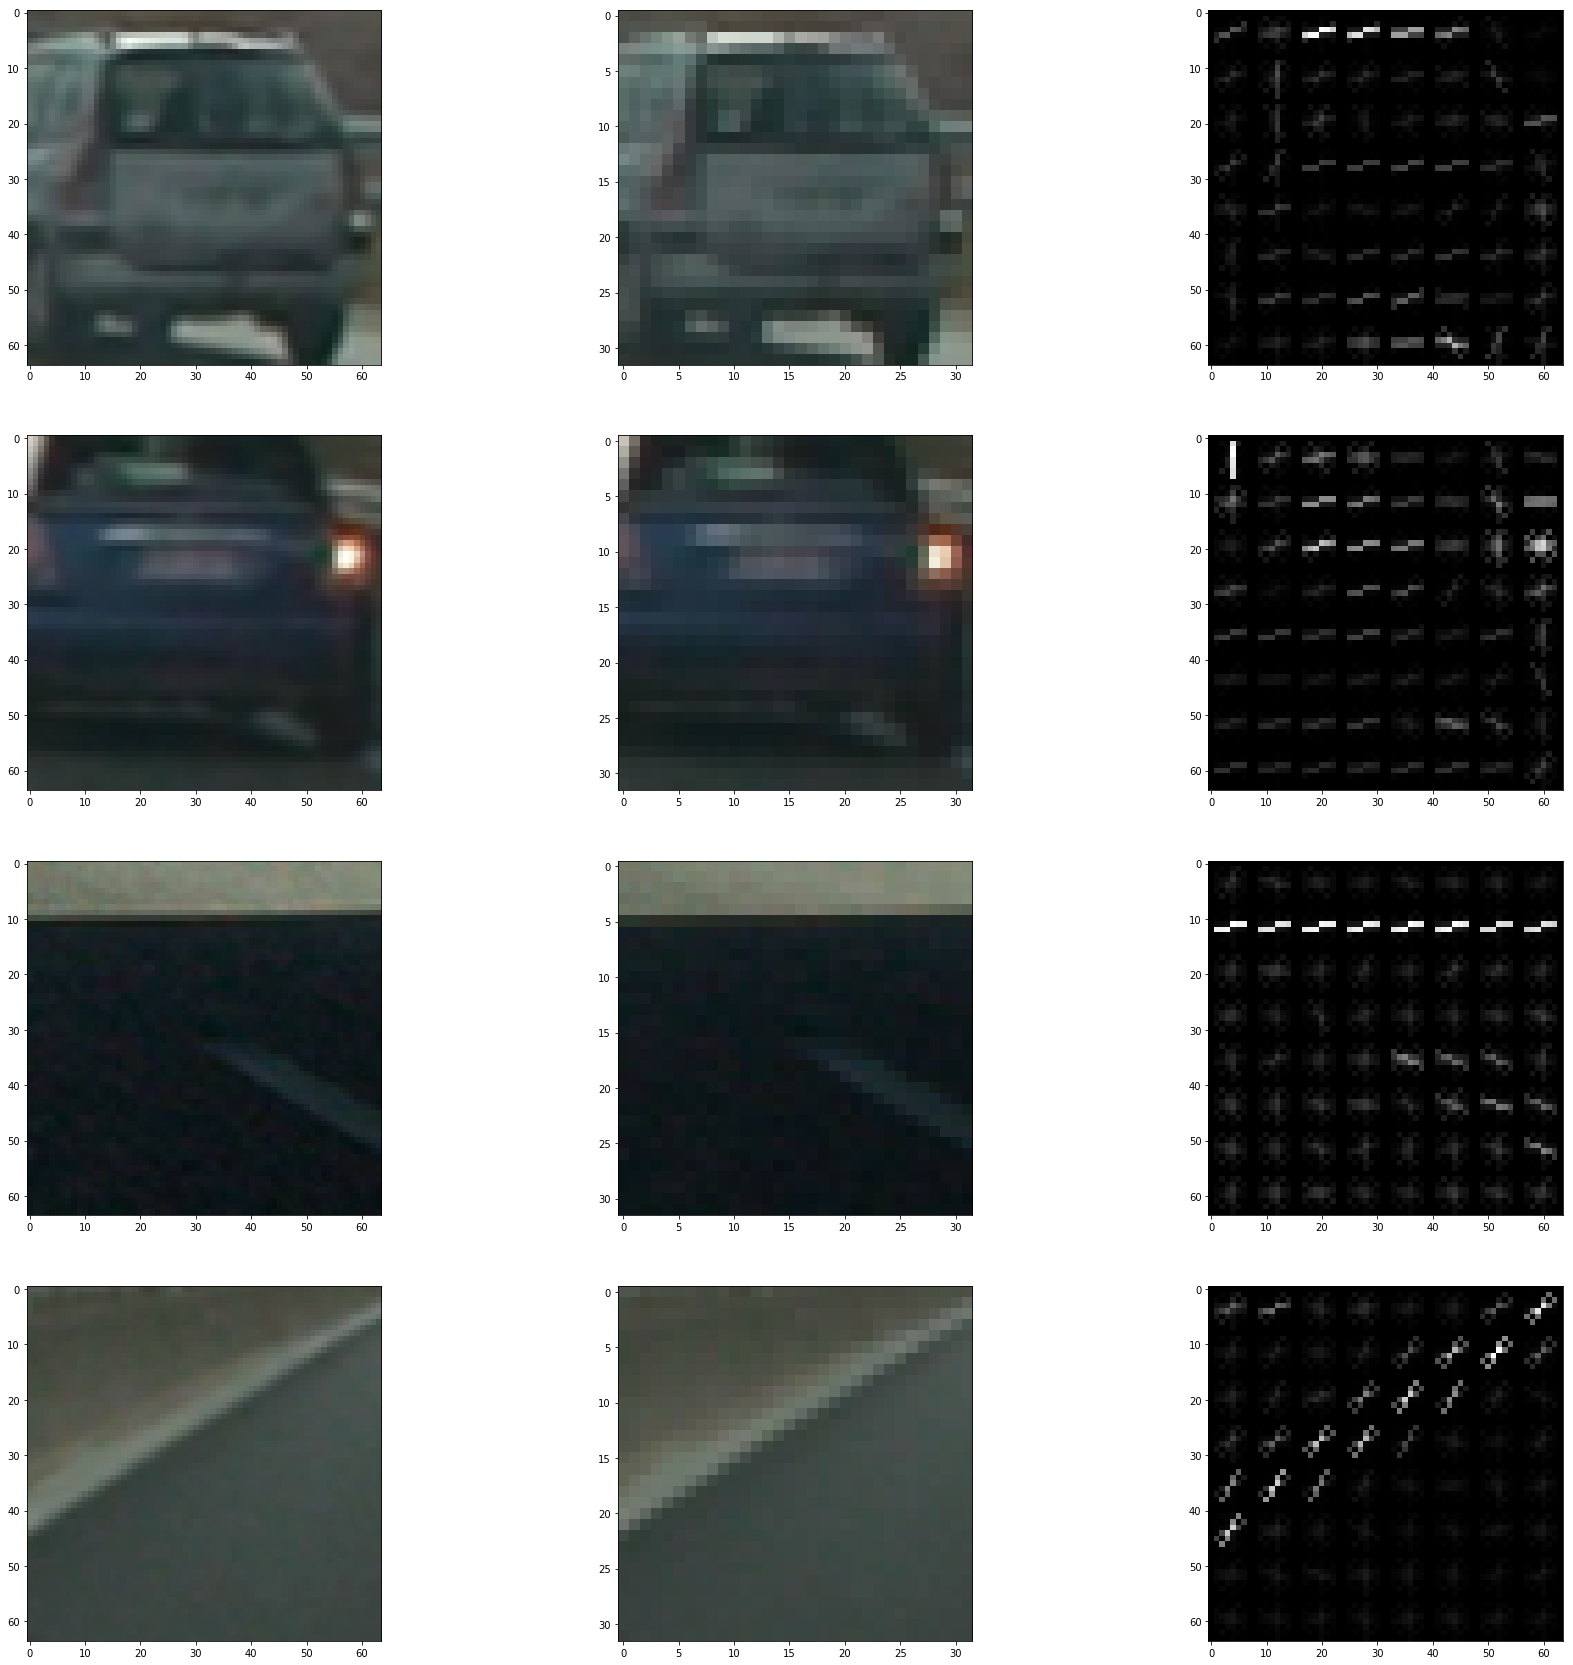

In [25]:


fig, ax = plt.subplots(4,3, figsize=(30, 30))
i = 0
orient = 9 # bins
pix_per_cell = 8
cell_per_block = 2

for file_name in cars[0:2]:
    car_img = mpimg.imread(file_name)
    ax[i][0].imshow(car_img)
    # Bin Spatial
    spatial_features = bin_spatial(car_img, (32, 32), False)
    ax[i][1].imshow(spatial_features)
    # Color Histogram. Image is read with mpimp. so the data is between 0 and 1
    channel1_hist = np.histogram(car_img[:,:,0], bins=32, range=(0,1))
    channel2_hist = np.histogram(car_img[:,:,1], bins=32, range=(0,1))
    channel3_hist = np.histogram(car_img[:,:,2], bins=32, range=(0,1))
    image_hls = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
    features, hog_image_hls = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                                               vis=True, feature_vec=True)
    ax[i][2].imshow(hog_image_hls, cmap='gray')
    i+=1
    
for file_name in notcars[0:2]:
    car_img = mpimg.imread(file_name)
    ax[i][0].imshow(car_img)
    # Bin Spatial
    spatial_features = bin_spatial(car_img, (32, 32), False)
    ax[i][1].imshow(spatial_features)
    # Color Histogram. Image is read with mpimp. so the data is between 0 and 1
    channel1_hist = np.histogram(car_img[:,:,0], bins=32, range=(0,1))
    channel2_hist = np.histogram(car_img[:,:,1], bins=32, range=(0,1))
    channel3_hist = np.histogram(car_img[:,:,2], bins=32, range=(0,1))
    image_hls = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
    features, hog_image_hls = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                                               vis=True, feature_vec=True)
    ax[i][2].imshow(hog_image_hls, cmap='gray')
    i+=1

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Train the classifier
    The features are extracted from the input images. Spatial and histogram information is also used.
    The data is normalized using Standard Scaler from sklearn. The parameters are below

In [7]:
# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL". The other channels have nan values
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# All the features are used for training
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)   

bad_indices = np.where(np.isnan(X))
print(bad_indices)
print(X[0])

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Car samples:  8792
Notcar samples:  8968
(array([], dtype=int64), array([], dtype=int64))
[  3.36353989e+01  -5.58325231e-01   3.52578807e+00 ...,   1.68529812e-03
   8.21653995e-04   2.61283741e-03]
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2628
3.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9814


In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def find_cars(img, ystart, yend, orient, pix_per_cell, cell_per_block, scale):
    boxes=[]
    draw_img = np.zeros_like(img)
    # Get the region of interest
    img_roi = img[ystart:ystop, :]
    # Convert the image to color space used for training
    img_roi = cv2.cvtColor(img_roi, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = img_roi.shape
        img_roi = cv2.resize(img_roi, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    # print(img_roi.shape)
    # Individual channels
    ch1 = img_roi[:,:,0]
    # ch2 = img_roi[:,:,1]
    # ch3 = img_roi[:,:,2]
    # Compute the individual channel HOG
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, False, feature_vec=False)
    # hog2 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, False, feature_vec=False)
    # hog3 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, False, feature_vec=False)
    # print(hog1.shape)
    """
    nx_block_samples = (ch1.shape[1]//pix_per_cell) - cell_per_block + 1
    ny_block_samples = (ch1.shape[0]//pix_per_cell) - cell_per_block + 1
    print(nx_block_samples)
    print(ny_block_samples)
    # features per block
    r_fearures_block = orient * cell_per_block**2
    print(r_fearures_block)
    """
    # Get the steps. These steps are for the entire image in x and y directions
    nx_blocks = hog1.shape[1]
    ny_blocks = hog1.shape[0]
    # print(nx_blocks)
    # print(ny_blocks)
    # Features per block
    n_features_block = hog1.shape[2] * hog1.shape[3] * hog1.shape[4]
    # print(n_features_block)
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    # No of blocks per window . 
    n_blocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # print(n_blocks_per_window)
    cells_per_step = 2 # Instead of overlap
    nx_window_steps = ((ch1.shape[1] - window) // (pix_per_cell * cells_per_step))
    ny_window_steps = ((ch1.shape[0] - window) // (pix_per_cell * cells_per_step)) 
    
    # Steps are one less than the no of blocks.
    # nxsteps = (nx_steps - n_blocks_per_window) // cells_per_step
    # nysteps = (ny_steps - n_blocks_per_window) // cells_per_step
    
    for xb in  range(nx_window_steps):
        for yb in range(ny_window_steps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract the gof features for the window
            hog_features = hog1[ypos:ypos+n_blocks_per_window, xpos:xpos+n_blocks_per_window].ravel()
            # hog_feat2 = hog2[ypos:ypos+n_blocks_per_window, xpos:xpos+n_blocks_per_window].ravel()
            # hog_feat3 = hog3[ypos:ypos+n_blocks_per_window, xpos:xpos+n_blocks_per_window].ravel()
            # hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(img_roi[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            h_stack_features = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

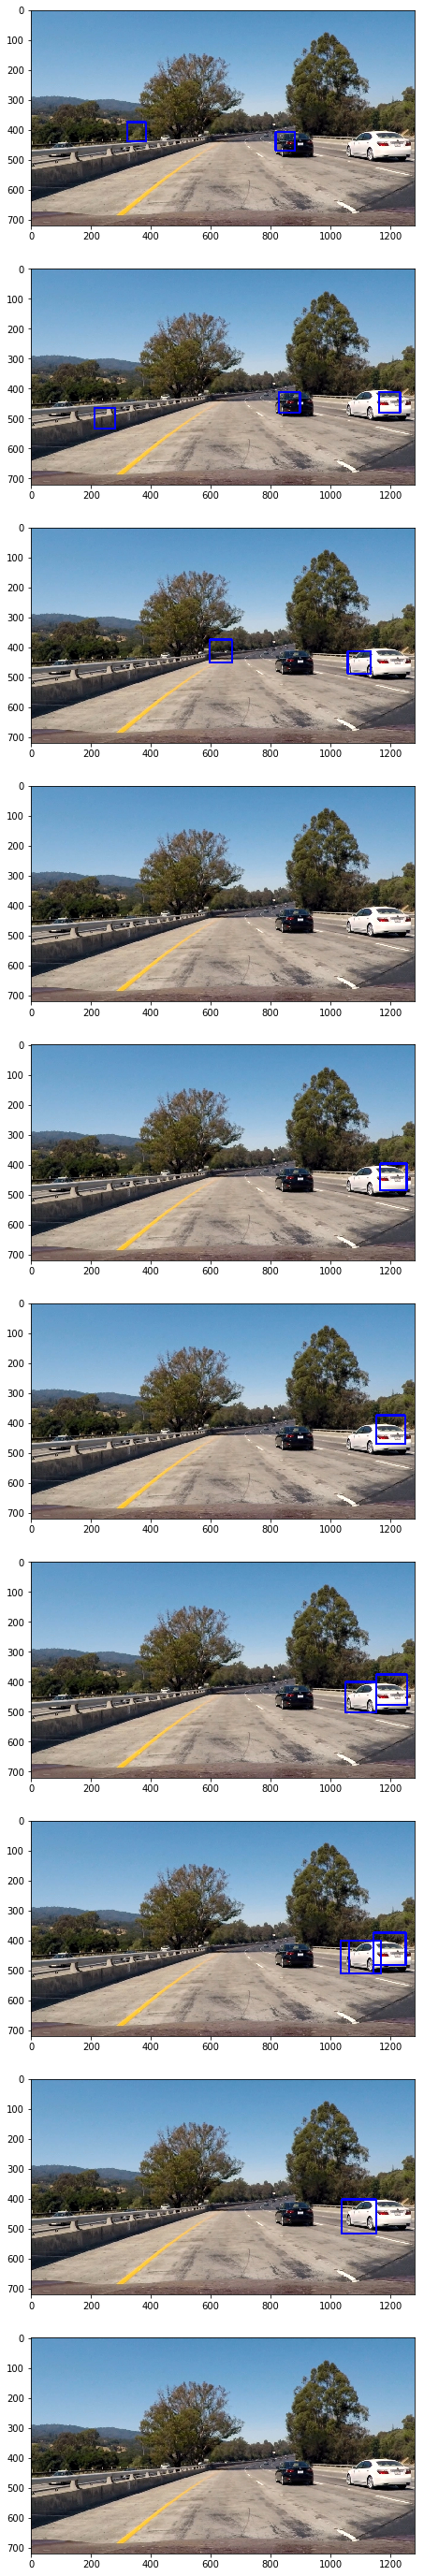

In [24]:
ystart = 375
ystop = 600
orient = 9
pix_per_cell = 8
cell_per_block = 2
# scale = 1
scales = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
fig, ax = plt.subplots(len(scales),1, figsize=(24, 50))
i = 0
file = glob.glob('test_png/test1.png')
for scale in scales:
    image = mpimg.imread('test_png/test1.png')
    # ax[i].imshow(image)
    windows = find_cars(image, ystart, ystop, orient, pix_per_cell, cell_per_block, scale)
    img = draw_boxes(image, windows, color= (0,0,1), thick = 6)
    ax[i].imshow(img)
    i+=1

## Hog Sub Sampling 
I have used Hog Subsampling provided with the lesson. The code is found in the lesson_functions.py. 
Changed to output rectangles along with image

## Find cars in the image.
    Tune the parameters to get the right region of interest.

In [ ]:
ystart = 350
ystop = 430

#color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#spatial_size = (32, 32)
#hist_bins = 32
#orient = 9
#pix_per_cell = 8
#cell_per_block = 2
#hog_channel = 'ALL'
#spatial_feat = False
#hist_feat = False
#hog_feat = True

scale = 1

idx = 1
fig = plt.figure(figsize=(30,30))

# for file in images:
image= mpimg.imread('test_png/test1.png')
windows = find_cars(image, ystart, ystop, 0, 96, scale, 2)
#find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, 
                        #cell_per_block, spatial_size, hist_bins, False)
search = draw_boxes(image, windows, (0,0,1), 6)
ax = fig.add_subplot(2,1,idx)
#ax.imshow(car_image)
#idx+=1
#ax = fig.add_subplot(2,1,idx)
ax.imshow(search)

## Sampling the pipeline for multiple hits
 The parameters are tuned to get the right pipeline. To remove false hits.

In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 375
ystop = 550
scale = 1.7
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)
ystart = 395
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(30,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 432
ystop = 588
scale = 1.9
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(30,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 2.2
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)
ystart = 464
ystop = 660
scale = 2.2
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(30,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 375
ystop = 550
scale = 1.7
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 395
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

ystart = 400
ystop = 520
scale = 1.4
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 432
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

ystart = 400
ystop = 558
scale = 1.9
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 432
ystop = 588
scale = 1.9
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

ystart = 400
ystop = 596
scale = 2.3
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 464
ystop = 660
scale = 2.2
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes: ', len(rectangles))
print('Number of boxes: ', len(rectangles[0]))
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

In [ ]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

In [ ]:
heatmap_img = apply_threshold(heatmap_img, 4)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

In [ ]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

In [ ]:
def process_frame(img):

    rects = []
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins = 32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    # color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #orient = 11
    #pix_per_cell = 16
    #cell_per_block = 2
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 375
    ystop = 550
    scale = 1.7
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 395
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 520
    scale = 1.4
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 558
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 588
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 596
    scale = 2.3
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 2.2
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 400
    ystop = 596
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

In [ ]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [ ]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

In [ ]:
def process_frame_for_video(img):

    rects = []
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins = 32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    # color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #orient = 11
    #pix_per_cell = 16
    #cell_per_block = 2
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    
    ystart = 375
    ystop = 550
    scale = 1.7
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 395
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 520
    scale = 1.4
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 558
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 588
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 596
    scale = 2.3
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 2.2
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 400
    ystop = 596
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
 
    rectangles = [item for sublist in rects for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

In [ ]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)